In [1]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [18]:
import h5py, os
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.optimize import curve_fit

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:95: RuntimeWarning: invalid value encountered in divide


[ 0.          1.          0.91666667  0.95238095  0.95238095  0.875       1.
  0.5         0.88888889  0.77777778  0.5         0.25        0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


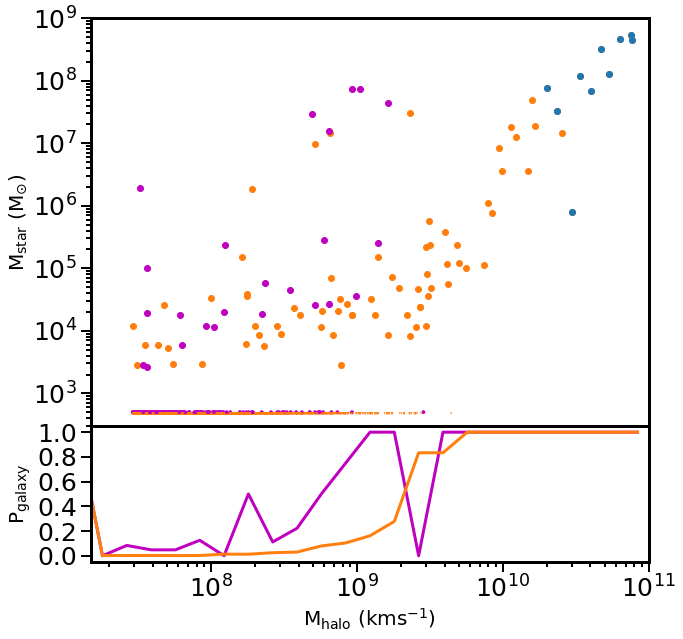

In [16]:
import hickle

plt.figure(1,(10,10))
gs = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0.0)
ax0 = plt.subplot(gs[0])
ax0.get_xaxis().set_visible(False)
plt.xscale('log')
plt.yscale('log')
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.xlabel('$M_{vir}$ ($M_{\odot}$)',fontsize=20)
plt.ylabel('$M_{star}$ ($M_{\odot}$)',fontsize=20)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([1.0e7,1.0e11])
plt.ylim([3.0e2,1.0e9])

empty_halos_sat = np.array([])
empty_halos_field = np.array([])
Vmax_empty_halos_sat = np.array([])
Vmax_empty_halos_field = np.array([])

all_halos_sat = np.array([])
all_halos_field = np.array([])
Vmax_all_halos_sat = np.array([])
Vmax_all_halos_field = np.array([])

for file_name in os.listdir('./hi_res_halo_limit_files/'):
    f_h = hickle.load('./hi_res_halo_limit_files/'+file_name)
    
    M_vir = np.asarray(f_h['M_vir'])
    M_star = np.asarray(f_h['M_star_gal'])
    non_zero_star = (M_star!=0.0)
    centers = f_h['centers']
    R_vir = f_h['R_vir']
    V_max = np.asarray(f_h['V_max'])
    M_cold_gas = np.asarray(f_h['M_gas_cold_rvir'])
    non_zero_gas = (M_cold_gas!=0.0)
    
    host_index = np.argmax(M_vir)
    host_pos = centers[host_index]
    
    halo_dist = np.linalg.norm(host_pos-centers,axis=1)

    sat_mask = (halo_dist<R_vir[host_index])&(halo_dist>0.0)

    #M_vir_sat = M_vir[sat_mask]
    #M_star_sat = M_star[sat_mask]
    #M_gas_sat = M_cold_gas[sat_mask]
    #V_max_sat = V_max[sat_mask]
    
    #M_vir_non_sat = M_vir[~sat_mask]
    #M_star_non_sat = M_star[~sat_mask]
    #M_gas_non_sat = M_cold_gas[~sat_mask]
    #V_max_non_sat = V_max[~sat_mask]

    #So I have 5 masks I need to to
    #1) host
    #2) sat non-zero
    #3) sat zero
    #4) field non-zero
    #5) field zero
    
    empty_halos_sat = np.concatenate([empty_halos_sat,M_vir[sat_mask&~non_zero_star]])
    empty_halos_field = np.concatenate([empty_halos_field,M_vir[~sat_mask&~non_zero_star]])
    Vmax_empty_halos_sat = np.concatenate([Vmax_empty_halos_sat,V_max[sat_mask&~non_zero_star]])
    Vmax_empty_halos_field = np.concatenate([Vmax_empty_halos_field,V_max[~sat_mask&~non_zero_star]])
    
    all_halos_sat = np.concatenate([all_halos_sat,M_vir[sat_mask]])
    all_halos_field = np.concatenate([all_halos_field,M_vir[~sat_mask]])
    Vmax_all_halos_sat = np.concatenate([Vmax_all_halos_sat,V_max[sat_mask]])
    Vmax_all_halos_field = np.concatenate([Vmax_all_halos_field,V_max[~sat_mask]])
    
    plt.figure(1,(10,10))
    ax0 = plt.subplot(gs[0])
    plt.scatter(M_vir[~sat_mask&non_zero_star],M_star[~sat_mask&non_zero_star],color='C1',label='non sats')
    plt.scatter(M_vir[host_index],M_star[host_index],color='C0',label='hosts')
    plt.scatter(M_vir[sat_mask&non_zero_star],M_star[sat_mask&non_zero_star],color='m',label='sats')
    plt.quiver(M_vir[~sat_mask&~non_zero_star],np.ones_like(M_vir[~sat_mask&~non_zero_star])*5.0e2,np.ones_like(M_vir[~sat_mask&~non_zero_star])*0.001,np.ones_like(M_vir[~sat_mask&~non_zero_star])*-1.0,color='C1',label='non sats',scale=2.0e2)
    plt.quiver(M_vir[sat_mask&~non_zero_star],np.ones_like(M_vir[sat_mask&~non_zero_star])*5.0e2,np.ones_like(M_vir[sat_mask&~non_zero_star])*0.001,np.ones_like(M_vir[sat_mask&~non_zero_star])*-1.0,color='m',label='non sats',scale=2.0e2)
    
M_halo_bins = np.logspace(7.0,11.0,25)
M_halo_bin_plot = [(M_halo_bins[ii]+M_halo_bins[ii+1])/2.0 for ii in range(len(M_halo_bins)-1)]
n_all_sat, bins_all_sat = np.histogram(all_halos_sat,bins=M_halo_bins)
n_empty_sat, bins_empty_sat = np.histogram(empty_halos_sat,bins=M_halo_bins)

frac_empty = np.nan_to_num(n_empty_sat.astype(float)/n_all_sat.astype(float))

print frac_empty

n_all_field, bins_all_field = np.histogram(all_halos_field,bins=M_halo_bins)
n_empty_field, bins_empty_field = np.histogram(empty_halos_field,bins=M_halo_bins)

frac_empty_field = np.nan_to_num(n_empty_field.astype(float)/n_all_field.astype(float))


ax1 = plt.subplot(gs[1])
plt.xscale('log')
plt.xlabel('$M_{halo}$ ($km s^{-1}$)',fontsize=20)
plt.ylabel('$P_{galaxy}$',fontsize=20)
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.plot(M_halo_bin_plot,1.0-frac_empty,color='m',linewidth=3)
plt.plot(M_halo_bin_plot,1.0-frac_empty_field,color='C1',linewidth=3)
plt.xlim([1.5e7,1.0e11])
#plt.ylim([0.0,1.0])
plt.savefig('./figs/M_star_M_halo.png')
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:111: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: RuntimeWarning: invalid value encountered in divide


[  2.66718967  20.98533531]


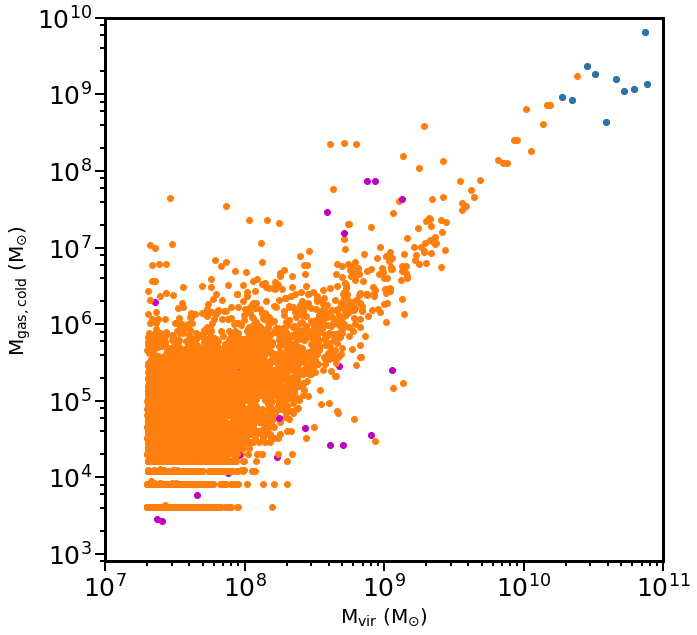

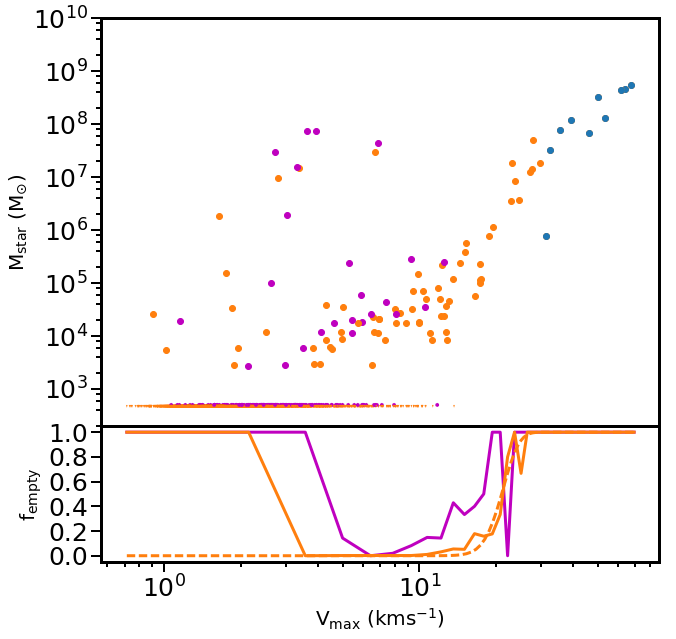

In [21]:
import hickle

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

plt.figure(2,(10,10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{vir}$ ($M_{\odot}$)',fontsize=20)
plt.ylabel('$M_{gas,cold}$ ($M_{\odot}$)',fontsize=20)
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([1.0e7,1.0e11])
plt.ylim([8.0e2,1.0e10])

plt.figure(3,(10,10))
gs3 = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0.0)
ax2 = plt.subplot(gs3[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$V_{max}$ ($km s^{-1}$)',fontsize=20)
plt.ylabel('$M_{star}$ ($M_{\odot}$)',fontsize=20)
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([1.0e7,1.0e11])
plt.ylim([2.0e2,1.0e10])

empty_halos_sat = np.array([])
empty_halos_field = np.array([])
Vmax_empty_halos_sat = np.array([])
Vmax_empty_halos_field = np.array([])

all_halos_sat = np.array([])
all_halos_field = np.array([])
Vmax_all_halos_sat = np.array([])
Vmax_all_halos_field = np.array([])

for file_name in os.listdir('./hi_res_halo_limit_files/'):
    f_h = hickle.load('./hi_res_halo_limit_files/'+file_name)
    
    M_vir = np.asarray(f_h['M_vir'])
    M_star = np.asarray(f_h['M_star_gal'])
    non_zero_star = (M_star!=0.0)
    centers = f_h['centers']
    R_vir = f_h['R_vir']
    V_max = np.asarray(f_h['V_max'])
    M_cold_gas = np.asarray(f_h['M_gas_cold_rvir'])
    non_zero_gas = (M_cold_gas!=0.0)
    
    host_index = np.argmax(M_vir)
    host_pos = centers[host_index]
    
    halo_dist = np.linalg.norm(host_pos-centers,axis=1)

    sat_mask = (halo_dist<R_vir[host_index])&(halo_dist>0.0)

    #M_vir_sat = M_vir[sat_mask]
    #M_star_sat = M_star[sat_mask]
    #M_gas_sat = M_cold_gas[sat_mask]
    #V_max_sat = V_max[sat_mask]
    
    #M_vir_non_sat = M_vir[~sat_mask]
    #M_star_non_sat = M_star[~sat_mask]
    #M_gas_non_sat = M_cold_gas[~sat_mask]
    #V_max_non_sat = V_max[~sat_mask]

    #So I have 5 masks I need to to
    #1) host
    #2) sat non-zero
    #3) sat zero
    #4) field non-zero
    #5) field zero
    
    empty_halos_sat = np.concatenate([empty_halos_sat,M_vir[sat_mask&~non_zero_star]])
    empty_halos_field = np.concatenate([empty_halos_field,M_vir[~sat_mask&~non_zero_star]])
    Vmax_empty_halos_sat = np.concatenate([Vmax_empty_halos_sat,V_max[sat_mask&~non_zero_star]])
    Vmax_empty_halos_field = np.concatenate([Vmax_empty_halos_field,V_max[~sat_mask&~non_zero_star]])
    
    all_halos_sat = np.concatenate([all_halos_sat,M_vir[sat_mask]])
    all_halos_field = np.concatenate([all_halos_field,M_vir[~sat_mask]])
    Vmax_all_halos_sat = np.concatenate([Vmax_all_halos_sat,V_max[sat_mask]])
    Vmax_all_halos_field = np.concatenate([Vmax_all_halos_field,V_max[~sat_mask]])
    
    plt.figure(2,(10,10))
    
    plt.scatter(M_vir[~sat_mask&non_zero_gas],M_cold_gas[~sat_mask&non_zero_gas],color='C1',label='non sats')
    plt.scatter(M_vir[host_index],M_cold_gas[host_index],color='C0',label='hosts')
    plt.scatter(M_vir[sat_mask&non_zero_gas],M_star[sat_mask&non_zero_gas],color='m',label='sats')
    plt.quiver(M_vir[~sat_mask&~non_zero_gas],np.ones_like(M_vir[~sat_mask&~non_zero_gas])*5.0e2,np.ones_like(M_vir[~sat_mask&~non_zero_gas])*0.001,np.ones_like(M_vir[~sat_mask&~non_zero_gas])*-1.0,color='C1',label='non sats',scale=2.0e2)

    
    plt.figure(3,(10,10))
    ax2 = plt.subplot(gs3[0])
    plt.scatter(V_max[~sat_mask&non_zero_star],M_star[~sat_mask&non_zero_star],color='C1',label='non sats')
    plt.scatter(V_max[host_index],M_star[host_index],color='C0',label='hosts')
    plt.scatter(V_max[sat_mask&non_zero_star],M_star[sat_mask&non_zero_star],color='m',label='sats')
    plt.quiver(V_max[~sat_mask&~non_zero_star],np.ones_like(V_max[~sat_mask&~non_zero_star])*5.0e2,np.ones_like(V_max[~sat_mask&~non_zero_star])*0.001,np.ones_like(V_max[~sat_mask&~non_zero_star])*-1.0,color='C1',label='non sats',scale=2.0e2)
    plt.quiver(V_max[sat_mask&~non_zero_star],np.ones_like(V_max[sat_mask&~non_zero_star])*5.0e2,np.ones_like(V_max[sat_mask&~non_zero_star])*0.001,np.ones_like(V_max[sat_mask&~non_zero_star])*-1.0,color='m',label='non sats',scale=2.0e2)

Vmax_bins = np.linspace(0.0,70.0,50)
Vmax_bins_plot = [(Vmax_bins[ii]+Vmax_bins[ii+1])/2.0 for ii in range(len(Vmax_bins)-1)]
Vmax_n_all_sat, bins_all_sat = np.histogram(Vmax_all_halos_sat,bins=Vmax_bins)
Vmax_n_empty_sat, bins_empty_sat = np.histogram(Vmax_empty_halos_sat,bins=Vmax_bins)

Vmax_frac_empty = 1.0-np.nan_to_num(Vmax_n_empty_sat.astype(float)/Vmax_n_all_sat.astype(float))

Vmax_n_all_field, bins_all_field = np.histogram(Vmax_all_halos_field,bins=Vmax_bins)
Vmax_n_empty_field, bins_empty_field = np.histogram(Vmax_empty_halos_field,bins=Vmax_bins)

Vmax_frac_empty_field = 1.0-np.nan_to_num(Vmax_n_empty_field.astype(float)/Vmax_n_all_field.astype(float))

#fit fractions
popt_fid, pcov_fid = curve_fit(normal_cdf, Vmax_bins_plot, Vmax_frac_empty_field,p0=[8.4,1.0])

print popt_fid
#print Vmax_bins
#print Vmax_bins_plot
#print Vmax_frac_empty
#print Vmax_frac_empty_field

V_fit = np.linspace(Vmax_bins_plot[0],Vmax_bins_plot[-1],100)

fit_field = normal_cdf(V_fit,*popt_fid)

ax3 = plt.subplot(gs3[1])
plt.xscale('log')
plt.xlabel('$V_{max}$ ($km s^{-1}$)',fontsize=20)
plt.ylabel('$f_{empty}$',fontsize=20)
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.plot(Vmax_bins_plot,Vmax_frac_empty,color='m',linewidth=3)
plt.plot(Vmax_bins_plot,Vmax_frac_empty_field,color='C1',linewidth=3)
plt.plot(V_fit,fit_field,color='C1',linestyle='--',linewidth=3)
#plt.xlim([1.0e7,1.0e11])
#plt.ylim([0.0,1.0])
#plt.savefig('./Vmax_fraction.png')
plt.show()